https://zvi975.tistory.com/65  
텐서플로 설치, 가상환경

# 요약

data는 다 있다.

예측해야하는것 : tag 10개, 곡 100개  
고려해야 할 점: 플레이리스트 update date와 곡 발매일자

val 데이터에 대한 답안 제출! - 리더보드용  
(최종은 test에 대한 답 제출)  

---

In [1]:
import tensorflow as tf

C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

In [5]:
# import libraries
import json
import re # regular expression
import gc # to collect memory
from datetime import datetime

import pandas as pd
import numpy as np

# for NLP
# from konlpy.tag import Kkma
# from konlpy.utils import pprint
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
# import missingno as msno

plt.style.use('seaborn')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_name = matplotlib.font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
matplotlib.rc('font', family = font_name)

---

# 1. 데이터 살펴보기

In [7]:
# load json files
with open("./res/genre_gn_all.json", encoding = 'utf-8') as json_file: genre = json.load(json_file)
with open("./res/song_meta.json", encoding = 'utf-8') as json_file: song_meta = json.load(json_file)
with open("./res/train.json", encoding = 'utf-8') as json_file: train = json.load(json_file)
with open("./res/val.json", encoding = 'utf-8') as json_file: valid = json.load(json_file)
    
# json to dataframe
df_genre = pd.Series(genre).to_frame('genre').reset_index().rename({'index' : 'gen_id'}, axis = 1)
df_song_meta = pd.DataFrame(song_meta)
df_train = pd.DataFrame(train)
df_valid = pd.DataFrame(valid)

## 1) 장르 data
### 1. 전체

In [13]:
df_genre

,gen_id,genre
0,GN0100,발라드
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
...,...,...
249,GN2900,뮤지컬
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬
252,GN2903,국외뮤지컬


국내와 해외로 구분 가능하다.  
숫자 값이 더 큰 장르가 해외 음악 장르이다.

### 2. 세부장르

In [20]:
# 장르코드 뒷자리 두 자리가 00이 아닌 코드를 필터링
#dtl: detailed
dtl_genre = df_genre[df_genre['gen_id'].str[-2:] != '00']
dtl_genre.rename(columns = {'gen_id' : 'dtl_gen_id', 'genre' : 'dtl_genre'}, inplace = True)

In [18]:
dtl_genre

,dtl_gen_id,dtl_genre
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
5,GN0105,'10-
...,...,...
247,GN2805,숙면유도
248,GN2806,반려동물
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬


### 3. 대분류 장르

In [24]:
# 장르코드 뒷자리 두 자리가 00인 코드를 필터링
main_genre = df_genre[df_genre['gen_id'].str[-2:] == '00']

In [25]:
main_genre

,gen_id,genre
0,GN0100,발라드
6,GN0200,댄스
12,GN0300,랩/힙합
18,GN0400,R&B/Soul
22,GN0500,인디음악
32,GN0600,록/메탈
39,GN0700,성인가요
50,GN0800,포크/블루스
56,GN0900,POP
65,GN1000,록/메탈


### 4. 장르 코드 트리

In [65]:
# 앞자리 네 자리 공통코드 추출
main_genre = main_genre.assign(join_code = main_genre['gen_id'].str[0:4])
dtl_genre  = dtl_genre.assign(join_code = dtl_genre ['dtl_gen_id'].str[0:4])

# Merge
gnr_code_tree = pd.merge(main_genre, dtl_genre , how = 'left', on = 'join_code')

gnr_code_tree[['gen_id', 'genre', 'dtl_gen_id', 'dtl_genre']]

,gen_id,genre,dtl_gen_id,dtl_genre
0,GN0100,발라드,GN0101,세부장르전체
1,GN0100,발라드,GN0102,'80
2,GN0100,발라드,GN0103,'90
3,GN0100,발라드,GN0104,'00
4,GN0100,발라드,GN0105,'10-
...,...,...,...,...
220,GN2800,뮤직테라피,GN2806,반려동물
221,GN2900,뮤지컬,GN2901,세부장르전체
222,GN2900,뮤지컬,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN2903,국외뮤지컬


## 참고
search하는 코드!

In [67]:
# POP 장르(GN0900)의 상세 장르 살펴보기
gnr_code_tree[gnr_code_tree['gen_id'] == 'GN0900']

,gen_id,genre,join_code,dtl_gen_id,dtl_genre
48,GN0900,POP,GN09,GN0901,세부장르전체
49,GN0900,POP,GN09,GN0902,얼터너티브팝
50,GN0900,POP,GN09,GN0903,올디스
51,GN0900,POP,GN09,GN0904,월드팝
52,GN0900,POP,GN09,GN0905,'60-'70
53,GN0900,POP,GN09,GN0906,'80-'90
54,GN0900,POP,GN09,GN0907,'00
55,GN0900,POP,GN09,GN0908,'10-


---

## 2) 곡 별 메타 데이터 Song meta

In [12]:
df_song_meta

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4
...,...,...,...,...,...,...,...,...,...
707984,[GN2001],19991219,The Best Best Of The Black President,65254,[166499],Coffin For Head Of State,[GN2000],[Fela Kuti],707984
707985,[GN0901],19860000,True Colors,44141,[11837],Change Of Heart,[GN0900],[Cyndi Lauper],707985
707986,"[GN0105, GN0101]",20160120,행보 2015 윤종신 / 작사가 윤종신 Live Part.1,2662866,[437],스치듯 안녕,[GN0100],[윤종신],707986
707987,"[GN1807, GN1801]",20131217,명상의 시간을 위한 뉴에이지 음악,2221722,[729868],숲의 빛,[GN1800],[Nature Piano],707987


#### song_meta의 데이터: 총 707989개
```
id: 곡 ID
album_id: 앨범 ID
artist_id_basket: 아티스트 ID 리스트
artist_name_basket: 아티스트 리스트
song_name: 곡 제목
song_gn_gnr_basket: 곡 장르 리스트
song_gn_dtl_gnr_basket: 곡 세부 장르 리스트
issue_date: 발매일
```

In [26]:
df_song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  object
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 48.6+ MB


---

## 3) train과 valid data

In [27]:
df_train

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000
...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000


In [37]:
df_valid

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[],118598,,"[373313, 151080, 275346, 696876, 165237, 52593...",1675,2019-05-27 14:14:33.000
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000
2,[],51464,,"[529437, 516103, 360067, 705713, 226062, 37089...",62,2008-06-21 23:26:22.000
3,[],45144,,"[589668, 21711, 570151, 320043, 13930, 599327,...",20,2017-10-30 18:15:43.000
4,[],79929,,"[672718, 121924, 102694, 683657, 201558, 38511...",20,2017-02-07 11:40:42.000
...,...,...,...,...,...,...
23010,[잔잔한],101722,,"[75842, 26083, 244183, 684715, 500593, 508608,...",17,2015-12-17 14:06:05.000
23011,"[어머니, 힘들때, 아빠, 가족, 위로받고싶을때]",122127,,"[450275, 487671, 561031, 663944, 628672, 59121...",10,2020-04-16 21:35:44.000
23012,[],77438,,"[625875, 464051, 11657, 236393, 358186, 213435...",0,2019-03-27 15:27:40.000
23013,[],36231,,"[161094, 665833, 688145, 432735, 439938, 12665...",31,2015-11-18 11:49:09.000


valid 데이터를 보면 song와 tag가 빠져있는데,  
각각 tag 10개, song 100개를 예측하면 된다.

#### 제출포맷
```
[
    {
        'id': 플레이리스트 id,
        'songs': 예측한 곡 100개 리스트,
        'tags': 예측한 태그 10개 리스트
    },
    ... (n개)
]
```

일단은 valid만 하면 되니까, test용은 따로 안보겠음

---


---

# 2. 곡별 매핑되는 장르 수

In [69]:
# 곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출
song_gnr_map = df_song_meta.loc[:, ['id', 'song_gn_gnr_basket']]

# unnest song_gn_gnr_basket
song_gnr_map_unnest = np.dstack(
    (
        np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))), 
        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
    )
)

# unnested 데이터프레임 생성 : song_gnr_map
song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)

# unnest 객체 제거
del song_gnr_map_unnest

In [70]:
song_gnr_map

,song_id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800
...,...,...
802854,707984,GN2000
802855,707985,GN0900
802856,707986,GN0100
802857,707987,GN1800


In [71]:
# 1. 곡 별 장르 개수 count 테이블 생성 : song_gnr_count
song_gnr_count = song_gnr_map.groupby('song_id').gnr_code.nunique().reset_index(name = 'mapping_gnr_cnt')

# 2. 1번에서 생성한 테이블을 가지고 매핑된 장르 개수 별 곡 수 count 테이블 생성 : gnr_song_count
gnr_song_count = song_gnr_count.groupby('mapping_gnr_cnt').song_id.nunique().reset_index(name = '매핑된 곡 수')

# 3. 2번 테이블에 비율 값 추가
gnr_song_count.loc[:, '비율(%)'] = round(gnr_song_count['매핑된 곡 수']/sum(gnr_song_count['매핑된 곡 수'])*100, 2)
gnr_song_count = gnr_song_count.reset_index().rename(columns = {'mapping_gnr_cnt' : '장르 수'})
gnr_song_count[['장르 수', '매핑된 곡 수', '비율(%)']]

,장르 수,매핑된 곡 수,비율(%)
0,1,612806,86.69
1,2,92378,13.07
2,3,1694,0.24
3,4,48,0.01
4,5,1,0.00
5,6,3,0.00


대부분 1곡의 장르와 매핑되어있다!

In [74]:
song_gnr_count[song_gnr_count['mapping_gnr_cnt'] >= 5]


,song_id,mapping_gnr_cnt
16032,114452,6
69927,163015,6
96859,187305,6
699170,92999,5


In [81]:
df_song_meta[df_song_meta['id'] == 92999]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
92999,"[GN1509, GN0902, GN2207, GN1001, GN2503, GN150...",20181226,In This Place (From &#34;Ralph Breaks the Inte...,10236571,[247582],In This Place (From &#34;Ralph Breaks the Inte...,"[GN2500, GN1500, GN0900, GN2200, GN1000]",[솔지 (EXID)],92999


---

# 3. 태그

In [85]:
# 플레이리스트 아이디(id)와 매핑된 태그(tags) 추출
plylst_tag_map = df_train[['id', 'tags']]

# unnest tags
plylst_tag_map_unnest = np.dstack(
    (
        np.repeat(plylst_tag_map.id.values, list(map(len, plylst_tag_map.tags))), 
        np.concatenate(plylst_tag_map.tags.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_tag_map = pd.DataFrame(data = plylst_tag_map_unnest[0], columns = plylst_tag_map.columns)
plylst_tag_map['id'] = plylst_tag_map['id'].astype(str)

# unnest 객체 제거
del plylst_tag_map_unnest

In [86]:
plylst_tag_map

,id,tags
0,61281,락
1,10532,추억
2,10532,회상
3,76951,까페
4,76951,잔잔한
...,...,...
476326,131982,퇴근길
476327,100389,노래추천
476328,100389,팝송추천
476329,100389,팝송


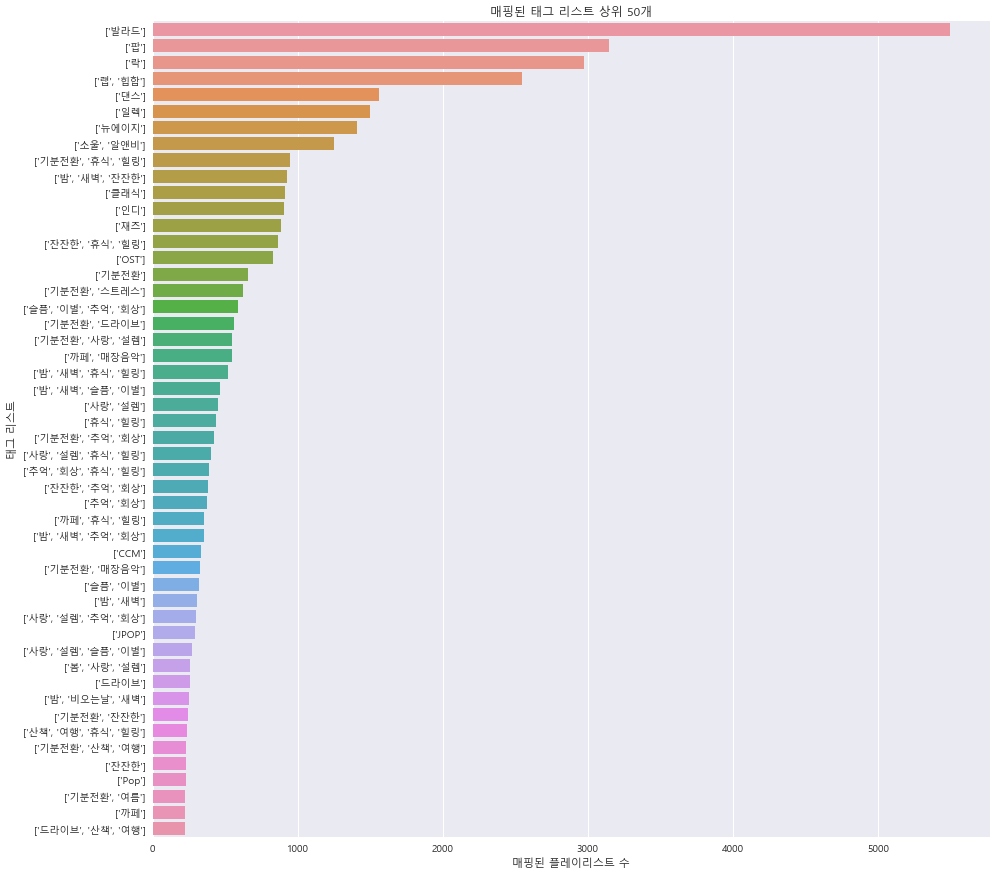

In [93]:
# 1. unnest 데이터프레임인 plylst_tag_map 테이블에서 태그 이름 정렬 후 list로 묶기
plylst_tag_list_sort = plylst_tag_map.sort_values(by = ['id', 'tags']).groupby('id').tags.apply(list).reset_index(name = 'tag_list')

# 2. 집계를 위해 1번 테이블에서 list 타입을 문자열 타입으로 변경
plylst_tag_list_sort['tag_list'] = plylst_tag_list_sort['tag_list'].astype(str)

# 3. 태그 리스트 별 매핑되는 플레이리스트 수 집계 테이블 생성 : tag_list_plylst_cnt
tag_list_plylst_cnt = plylst_tag_list_sort.groupby('tag_list').id.nunique().reset_index(name = 'plylst_cnt')

# 4. 매핑 수 기준 상위 50개 필터링
tag_list_plylst_cnt = tag_list_plylst_cnt.nlargest(50, 'plylst_cnt')

# 5. plotting
plt.figure(figsize = (15, 15))
tag_list_plylst_cnt_plot = sns.barplot(y = 'tag_list', x = 'plylst_cnt', data = tag_list_plylst_cnt)
tag_list_plylst_cnt_plot.set_title('매핑된 태그 리스트 상위 50개')
tag_list_plylst_cnt_plot.set_xlabel('매핑된 플레이리스트 수')
tag_list_plylst_cnt_plot.set_ylabel('태그 리스트')
plt.show()